# This code performs the 24 hour analysis of NO2 dynamics.

In [17]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import pickle
import scipy.stats as stats
from sklearn.covariance import ledoit_wolf
import seaborn as sns
import matplotlib
sns.set()
sns.set_context("talk", font_scale = 1)
sns.set_style('whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
# matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
# matplotlib.rcParams['figure.figsize'] = [10, 7]
# %matplotlib inline

In [18]:
df = pd.read_csv(r"C:\Users\17345\workingpapers\Atmospheric_Riemannian\AtmosphericData\AtmosphericData\data\Hourly_data_of_Beijing_from_Jinxi_20210305.csv", delimiter = ',')
latlon = pd.read_csv(r"C:\Users\17345\workingpapers\Atmospheric_Riemannian\AtmosphericData\AtmosphericData\data\latlondata.csv",delimiter = ',')

In [19]:
df = df.interpolate(method='linear', axis=0)
df1 = df.iloc[:, 12]

In [20]:
df1

0         76.0
1         75.0
2         73.0
3         72.0
4         73.0
          ... 
297835    67.0
297836    64.0
297837    59.0
297838    55.0
297839    60.0
Name: NO2, Length: 297840, dtype: float64

In [21]:
#Indices for unique values

Sites = df.Site.unique()
Dates = df.Date.unique()
Months = df.Month.unique()
holi = df.Holiday.unique()
hours = df.Hour.unique()
dow = df.DOW.unique()

# Visualize Data for 24 Hour Period

In [36]:
Sites = Sites[np.where(Sites != 'TT')[0]]

Matrices = []
labels = []
Covs = []
coord = []
numz = []

mats = []

for j in tqdm(hours):

    Matrices = []
    
    for i in Sites:
        Data = df1.loc[(df['Site'] == i) & (df['Hour'] == j) & (df['Date'] == Dates[0])]
        label = df.loc[(df['Site'] == i) & (df['Hour'] == j) & (df['Date'] == Dates[0])].iloc[:,0]

        Matrices.append(Data.values)
    
    Matricez = np.stack(Matrices).T
    
    mats.append(Matricez)


  0%|          | 0/24 [00:00<?, ?it/s]

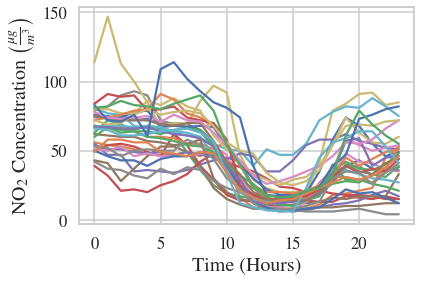

In [24]:
plt.plot(np.vstack(mats))

plt.xlabel("Time (Hours)",fontsize = 20)

plt.ylabel(r"NO$_2$ Concentration $\left(\frac{\mu g}{m^3}\right)$",fontsize = 20)

plt.savefig("NO2_time.svg")

# Create Covariance Matrices for Analysis

In [42]:
Sites = Sites[np.where(Sites != 'TT')[0]]

Matrices = []
labels = []
Covs = []
coord = []
numz = []

for j in tqdm(hours):
    
    Matrices = []
    
    for i in Sites:
        Data = df1.loc[(df['Site'] == i) & (df['Hour'] == j)]
        label = df.loc[(df['Site'] == i) & (df['Hour'] == j)].iloc[:,0]
        
        Matrices.append(Data.values)
    
    labels.append(j)

    Matricez = np.stack(Matrices).T

    Wcov = ledoit_wolf(Matricez)[0]

    Covs.append(Wcov)

  0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\17345\AppData\Local\Temp\ipykernel_11760\1571751679.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


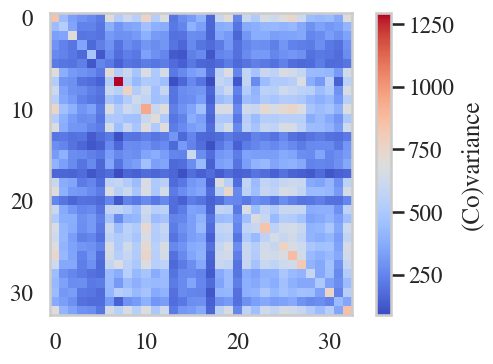

In [43]:
plt.figure(dpi = 100)
plt.grid(False)

x = [0,1,2,3,4,5]

plt.imshow(Covs[0],cmap = 'coolwarm')

cbar = plt.colorbar()
cbar.set_label('(Co)variance')

plt.savefig("NO2_Cov.svg")

In [44]:
coord = []

for i in Sites:
    lon = latlon.loc[latlon['Site'] == i].iloc[:,1]
    lat = latlon.loc[latlon['Site'] == i].iloc[:,2]
    coord.append(np.hstack([lat,lon]))
    

# Perform Riemannian Geometric Analysis

In [45]:
#Define a few matrix operations

def logarithm(cov):
    d, V = np.linalg.eigh(cov)
    D = np.diag(np.log(d))
    logcov = np.dot(np.dot(V, D), V.T)
    return logcov

def sqrroot(cov):
    d, V = np.linalg.eigh(cov)
    D = np.diag(np.sqrt(d))
    sqrroot = np.dot(np.dot(V, D), V.T)
    return sqrroot

def expstep(cov,step):
    d, V = np.linalg.eigh(cov)
    D = np.diag(np.exp(d*step))
    expstep = np.dot(np.dot(V, D), V.T)
    return expstep

def mat_op(operation,d,V):
    return np.dot(V*operation(d),V.T)

Text(0, 0.5, 'Loss')

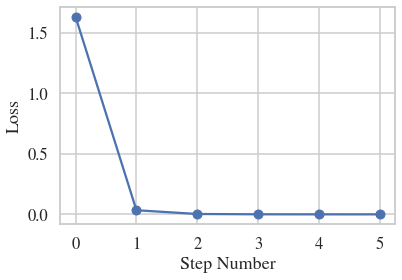

In [46]:
#Use optimization to identify the geometric mean of the previously computed covariance matrices 
#using gradient descent on the Riemannian Manifold.

#Initialize the Matrix Mean:
Covs = np.array(Covs)
geomean = np.mean(Covs,axis = 0)

#Initialize the gradient descent step size and loss:
step = 1
norm_old = np.inf

#Set tolerance:
tol = 1e-8
norms = []

for n in range(100):

    #Compute the gradient
    geo_eval,geo_evec = np.linalg.eigh(geomean)
    geomean_inv_sqrt = mat_op(np.sqrt,1. / geo_eval,geo_evec)
    
    #Project matrices to tangent space and compute mean and norm:
    mats= [geomean_inv_sqrt.dot(cov).dot(geomean_inv_sqrt) for cov in Covs]
    log_mats = [logarithm(mat) for mat in mats]
    meanlog = np.mean(log_mats,axis = 0)
    norm = np.linalg.norm(meanlog)

    #Take step along identified geodesic to minimize loss:
    geomean_sqrt = sqrroot(geomean)
    geomean = geomean_sqrt.dot(expstep(meanlog,step)).dot(geomean_sqrt)

    # Update the norm and the step size
    if norm < norm_old:
        norm_old = norm

    elif norm > norm_old:
        step = step / 2.
        norm = norm_old

    if tol is not None and norm / geomean.size < tol:
        break
        
    norms.append(norm)
    
plt.plot(norms,'o-')

plt.xlabel("Step Number")

plt.ylabel("Loss")

In [47]:
#We have now identified the mean, and project our matrices to the tangent space centered at this mean.

geo_eval,geo_evec = np.linalg.eigh(geomean)

geomean_inv_sqrt = mat_op(np.sqrt,1. / geo_eval,geo_evec)

def T_Project(geomean_inv_sqrt,cov):
    newmat = geomean_inv_sqrt.dot(cov).dot(geomean_inv_sqrt)
    T_cov = logarithm(newmat)
    return T_cov

T_covs = [T_Project(geomean_inv_sqrt,cov) for cov in Covs]

flat_covs = [np.ndarray.flatten(T_cov) for T_cov in T_covs]

# Principal Component Analysis

In [48]:
pca = PCA()

X = pca.fit_transform(flat_covs)

C:\Users\17345\AppData\Local\Temp\ipykernel_11760\609798748.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


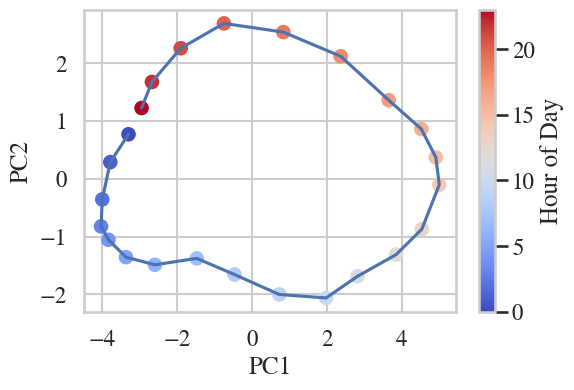

In [49]:
plt.figure(dpi = 100)

plt.plot(X[:,0],X[:,1])
plt.scatter(X[:,0],X[:,1],c = labels,cmap = 'coolwarm')


plt.xlabel("PC1")

plt.ylabel("PC2")

cbar = plt.colorbar()

cbar.set_label("Hour of Day")

plt.savefig("NO2_data_tangent.eps")

In [50]:
w = pca.components_

C:\Users\17345\AppData\Local\Temp\ipykernel_11760\3481452322.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


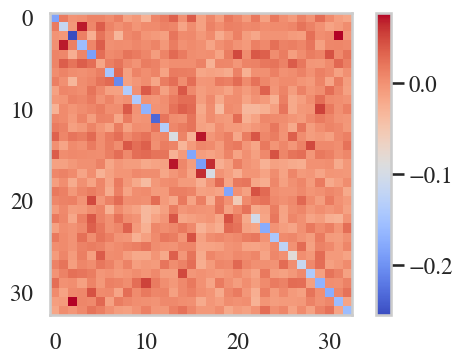

In [51]:
plt.figure(dpi = 100)
plt.grid(False)
# xlab = df1.columns.values
# ylab = df1.columns.values

x = [0,1,2,3,4,5]

plt.imshow(w[0,:].reshape(33,33),cmap = 'coolwarm')


# plt.xticks(x,xlab,rotation = 'vertical')
# plt.yticks(x,xlab)

plt.colorbar()



C:\Users\17345\AppData\Local\Temp\ipykernel_11760\2929384401.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


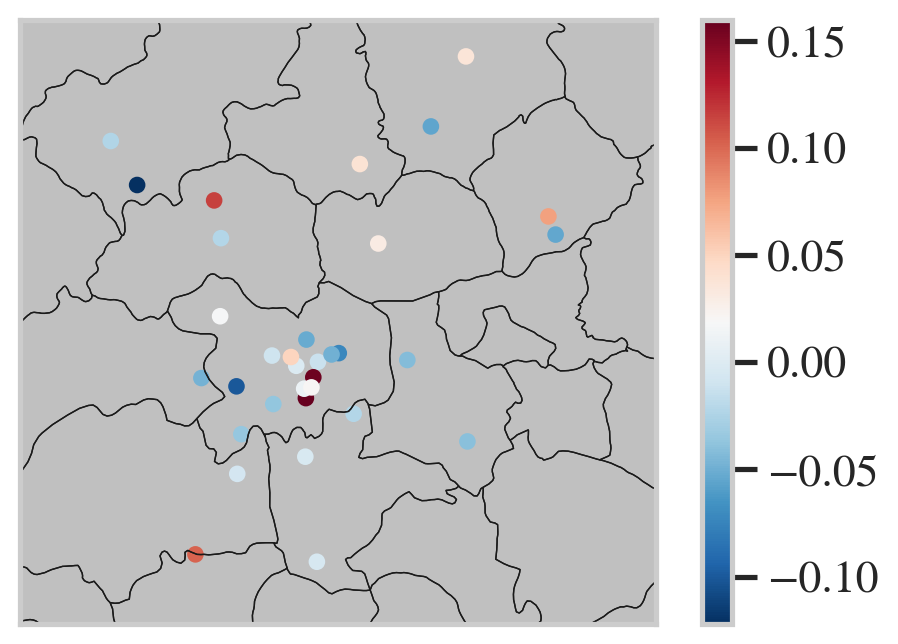

In [52]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(dpi = 200)
m= Basemap(llcrnrlon=115.5, llcrnrlat=39.5, urcrnrlon=117.5, urcrnrlat=40.5, projection='lcc', lat_1=33, lat_2=45, lon_0=100) 
m.readshapefile(r'gadm36_CHN_3', 'counties', drawbounds = True)
m.drawcountries(color='#ffffff', linewidth=0.5)
m.fillcontinents(color='#c0c0c0', lake_color='#ffffff')

i = 0

xs = []
ys = []

for a,b in coord:
    
    x, y = m(b,a)
    
    xs.append(x)
    ys.append(y)

    
plt.scatter(xs, ys, s = 20, c = np.diag(w[0,:].reshape(33,33)) - np.mean(np.diag(w[0,:].reshape(33,33))),cmap = "RdBu_r")
  
plt.colorbar()
    
plt.savefig("Beijing_map_colored.eps")

